 # Predicting Heart Disease Using Medical Data with the KNN Algorithm  
 
 
 #### By Chris Jung, Jamie Ma and Amy Wu
 
 ## Background and Motivation
- ***Heart disease*** is the leading casue of death  for men, women, and people of most racial and ethnic groups in most of countries in the world, even in the countries with developed medical technology such as the United States.<br>
- About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths. It costs the United States about $363 billion each year from 2016 to 2017. [Reference 1](https://www.cdc.gov/heartdisease/facts) , [Reference 2](https://www.who.int/health-topics/cardiovascular-diseases)
- For those reasons, it would be beneficial for both our society and individuals if we can analyze the factors causing heart disease, predict heart disease using the analysis and prevent it from happening beforehand. 

## Project Goal
- For this reason, we are going to use actual medical records from the Cleveland Clinic Foundation to make a **heart disease prediction model** using the K-nearest neighbors (KNN) classification algorithm.
- Then we will **evalutate our model** to determine if it is good model by analyzing the prameters and accuracy of the model.
- By doing these activities, we hope to answer this question:

##### Given a new observation with age, blood pressure, cholesterol, max heart rate, and ST depression as predictors, can we accurately predict the **presence** of heart disease?


## Data
- The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
- Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease.
- We will predict the attribute "Class" which represents the presence of heart disease in 5 different categories.
- We will only use the 5 attributes that are numerical/non-categorical out of the 14 total attributes as predictors. 
- The 5 predictors and 1 *class* to predict are:
    1. age: age of the person in years
    2. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    3. chol: serum cholestoral in mg/dl
    4. thalach: maximum heart rate achieved in bpm (Beat Per Minute)
    5. oldpeak: ST depression induced by exercise relative to rest in mm
    6. *class*: presence of heart disease: no presence (0) and presence (1-4)

In [2]:
#loads the libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

#sets the seed for random events such as splitting the data
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Reading and Wrangling the Data

In [3]:
#reads in the data table with the 14 attributes
heart_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13), X14 = as.factor(X14))

#outputs the first 6 rows of the data frame
head(heart_data_raw)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `X12`.
ℹ NAs introduced by coercion
ℹ Input `X12` is `as.numeric(X12)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X13`.
ℹ NAs introduced by coercion
ℹ Input `X13` is `as.numeric(X13)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Since the columns are separated by commas, we used `read_csv` to read the file from the web. After loading in the data, we noticed that columns `X12` and `X13` were being treated as characters, not doubles, so we used `mutate` and `as.numeric` to change the data types. In addition, since `X14` corresponds to the class of heart diseases, we needed to convert that column to a factor by using `as.factor`.

In [4]:
#renames the columns
colnames(heart_data_raw) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 5 predictors and class that will be used as well as converts the class into either 'low' for value = 0 or 'high' for value = [1-4]
heart_data <- select(heart_data_raw, age, trestbps, chol, thalach, oldpeak, Class) %>%
     mutate(Class = case_when((Class == 0) ~ "low", (Class != 0) ~ 'high'))

#outputs the first 6 rows of the data frame
head(heart_data)

age,trestbps,chol,thalach,oldpeak,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
63,145,233,150,2.3,low
67,160,286,108,1.5,high
67,120,229,129,2.6,high
37,130,250,187,3.5,low
41,130,204,172,1.4,low
56,120,236,178,0.8,low


In order to finish wrangling the data, we converted the column names into names that are human-readable. We decided to convert them all into the names given by the data set as outlined in the introduction, with the exception of the last column which we named `Class`. In addition, since we are only interested in whether or not there is the presence of heart disease or not, we replaced any values of 0 with `low` and any other values (1-4) with `high`.

In [5]:
#splits the data into training and test data
heart_split <- initial_split(heart_data, prop = 0.75, strata = Class)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split) 

When splitting up the data into training and test data, we chose a 75/25 split because that would offer the model a good balance between optimizing its accuracy through training data, while also maintaining enough data to test the accuracy through testing data. Since `Class` corresponds to the variable we are trying to predict, we made sure to specify it with `strata`.

# Exploratory Data Analysis
## Summarizing the Data

Below, we have created two tables to summarize the data. The first calculates the proportion of each `Class` within the training data. The second displays statistical measurements such as `min`, `max`, `median`, and `mean` of the training data set for all predictors.

In [6]:
#creates a table that displays the count and percentage of each class in the training data
heart_proportions <- heart_training %>%
                      group_by(Class) %>%
                      summarize("count" = n()) %>%
                      mutate(percent = 100*count/nrow(heart_training))
heart_proportions

`summarise()` ungrouping output (override with `.groups` argument)



Class,count,percent
<chr>,<int>,<dbl>
high,105,46.05263
low,123,53.94737


By looking at the table above, an observation that we made was that the data points are not equally distrubuted amongst the classes, but rather there are just as many data points corresponding to `Class = 0` as there are corresponding to all of the other classes combined.

In [7]:
#creates a data table with the mean, median, min, and max values of each predictors
heart_median <- heart_training %>%
                select(-Class) %>%
                map_df(median, na.rm = TRUE) %>% 
                mutate(Stat = "median")
heart_mean <- heart_training %>%
                select(-Class) %>%
                map_df(mean, na.rm = TRUE) %>%
                t() %>%
                round(digits = 2) %>%
                t() %>%
                as.tibble() %>%
                mutate(Stat = "mean")
heart_min <- heart_training %>%
                select(-Class) %>%
                map_df(min, na.rm = TRUE) %>% 
                mutate(Stat = "min")
heart_max <- heart_training %>%
                select(-Class) %>%
                map_df(max, na.rm = TRUE) %>% 
                mutate(Stat = "max")

#combines all of the statistical measurements into one table
heart_averages <- rbind(heart_median, heart_mean, heart_min, heart_max)
heart_averages

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


age,trestbps,chol,thalach,oldpeak,Stat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
55.00,130.00,239.50,153.50,0.80,median
54.08,131.71,245.54,149.82,1.04,mean
29.00,94.00,126.00,71.00,0.00,min
71.00,200.00,564.00,202.00,6.20,max


## Visualizing the Data

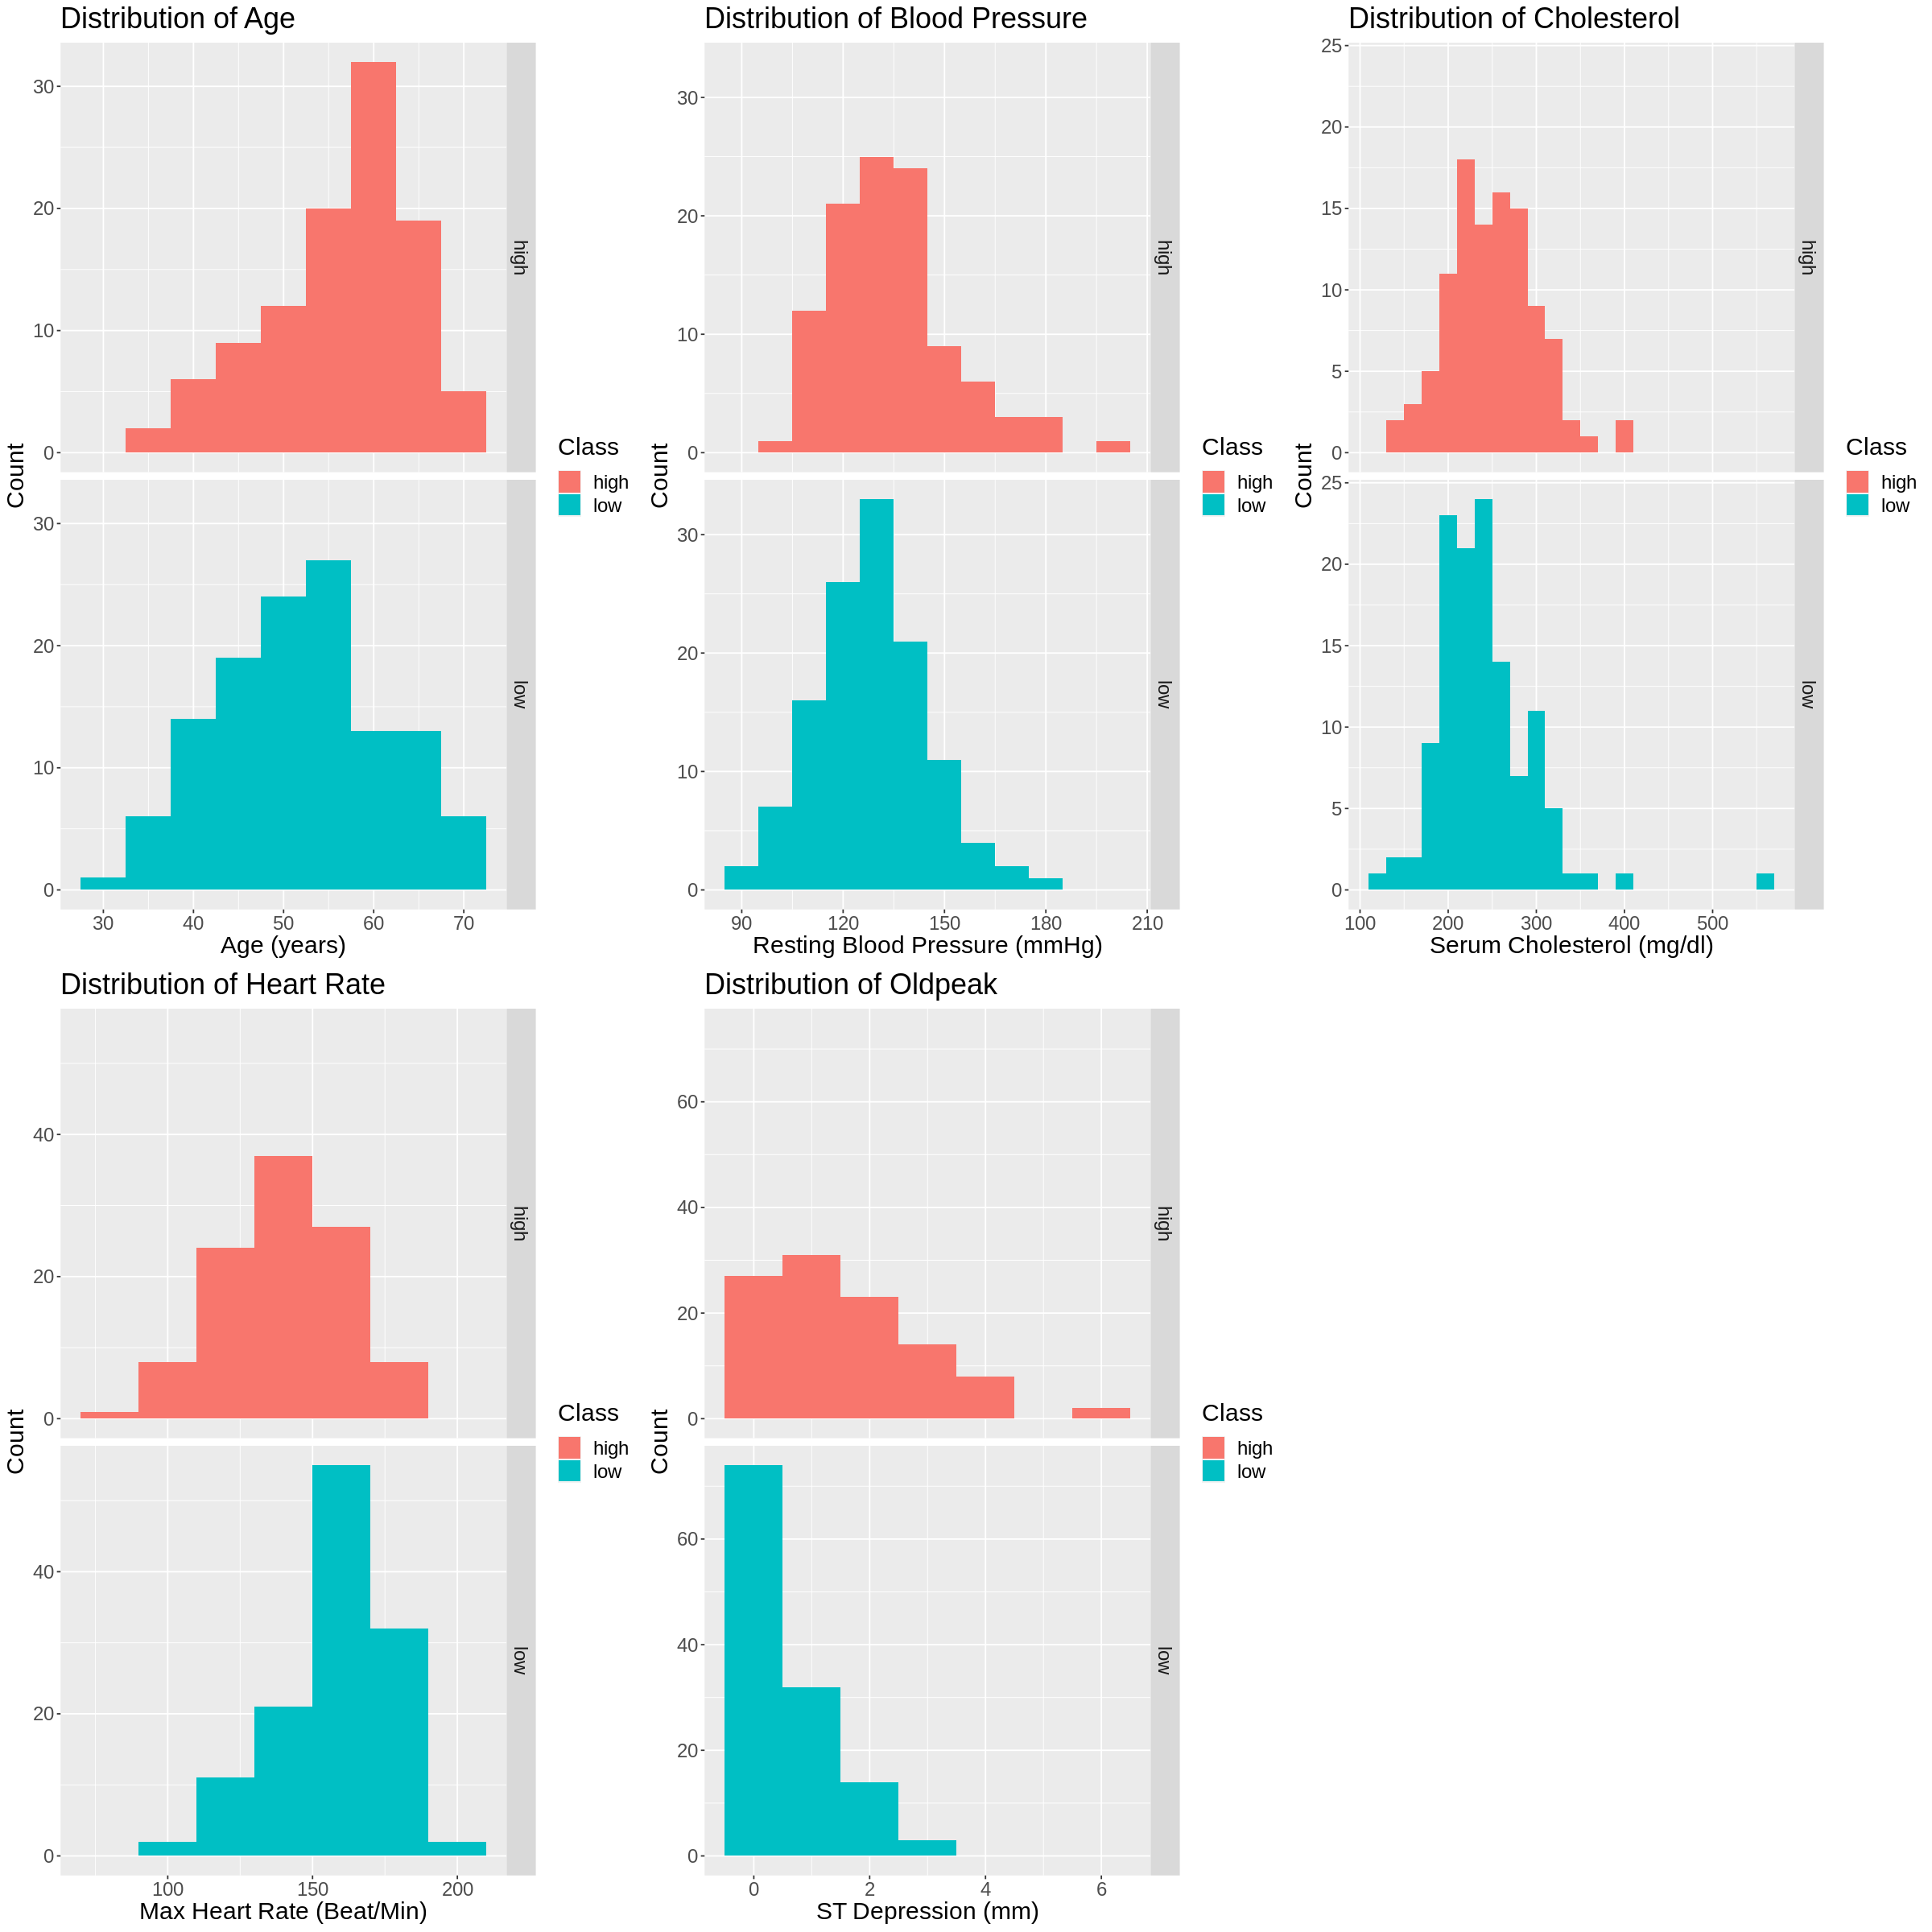

In [8]:
options(repr.plot.width = 20, repr.plot.height = 20)

#plots for each individual predictor
age_plot <- ggplot(heart_training, aes(x=age, fill = Class)) +
            geom_histogram(binwidth = 5) +
            labs(x="Age (years)",y="Count",title="Distribution of Age") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Class))
trestbps_plot <- ggplot(heart_training, aes(x=trestbps, fill = Class)) +
            geom_histogram(binwidth = 10) +
            labs(x="Resting Blood Pressure (mmHg)",y="Count",title="Distribution of Blood Pressure") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Class))
chol_plot <- ggplot(heart_training, aes(x=chol, fill = Class)) +
            geom_histogram(binwidth = 20) +
            labs(x="Serum Cholesterol (mg/dl)",y="Count",title="Distribution of Cholesterol") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Class))
thalach_plot <- ggplot(heart_training, aes(x=thalach, fill = Class)) +
            geom_histogram(binwidth = 20) +
            labs(x="Max Heart Rate (Beat/Min)",y="Count",title="Distribution of Heart Rate") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Class))
oldpeak_plot <- ggplot(heart_training, aes(x=oldpeak, fill = Class)) +
            geom_histogram(binwidth = 1) +
            labs(x="ST Depression (mm)",y="Count",title="Distribution of Oldpeak") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Class))

#displays the 5 plots side-by-side
grid.arrange(age_plot,trestbps_plot,chol_plot, thalach_plot,oldpeak_plot, ncol = 3)

For our visualizations, we decided to create a histogram for each predictor displaying how the distrubution of that individual predictor changes based on the presence of heart disease. Due to this, we created an individual plot for each histogram so that we could change the `binwidth` and labels for each graph. Then, we used the `grid.arrange` function from the `gridExtra` package to place multiple plots side-by-side.

# Data Analysis

To begin our data analysis, we will want to create a recipe specifying our data, predictors, and class. Since we are going to be using multiple predictors with varying scales, we will want to use `step_scale` and `step_center` to normalize the data.

In [22]:
#creates the recipe 
heart_recipe <- recipe(Class ~ ., data = heart_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, since we will be performing a KNN classification, we will want to use the `nearest_neighbor` function, set the engine to `"kknn"`, and set the mode to `"classification"`. In addition, since we want to determine the optimal K value that produces the highest accuracy, we will use the `tune()` function in the `neighbors` argument.

In [23]:
#creates the specification for the model
heart_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


As mentioned earlier, since we want to determine the optimal K value, we will use 5 fold cross validation. Since the training data set only has about 225 observations, we believe that using 5 fold validation provides a good balance between the number of observations in the validation set as well as in the training set. If we used a higher number such as 10, each group would have a very limited number of observations resulting in a higher likelihood of outliers in each set.

In [24]:
#performs 5 fold cross validation
heart_vfold <- vfold_cv(heart_training, v=5, strata = Class)

Next, we create a workflow by adding the `heart_recipe` and the `heart_spec` model.

In [25]:
#creates a workflow
heart_workflow <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec)
heart_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [ ]:
Lastly, to determine the general range of optimal K values, we want to test all values 

In [27]:
gridvals <- tibble(neighbors = seq(from = 20, to = 80, by = 5))

heart_results <- heart_workflow %>%
    tune_grid(resamples = heart_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
heart_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
60,accuracy,binary,0.7106280,5,0.03391463,Model09
65,accuracy,binary,0.7105314,5,0.03113653,Model10
70,accuracy,binary,0.7105314,5,0.03472432,Model11
45,accuracy,binary,0.7061836,5,0.03998074,Model06
40,accuracy,binary,0.7061836,5,0.03802715,Model05
75,accuracy,binary,0.7061836,5,0.03194892,Model12
80,accuracy,binary,0.7060870,5,0.03296534,Model13
50,accuracy,binary,0.6975845,5,0.03137160,Model07
55,accuracy,binary,0.6975845,5,0.03137160,Model08


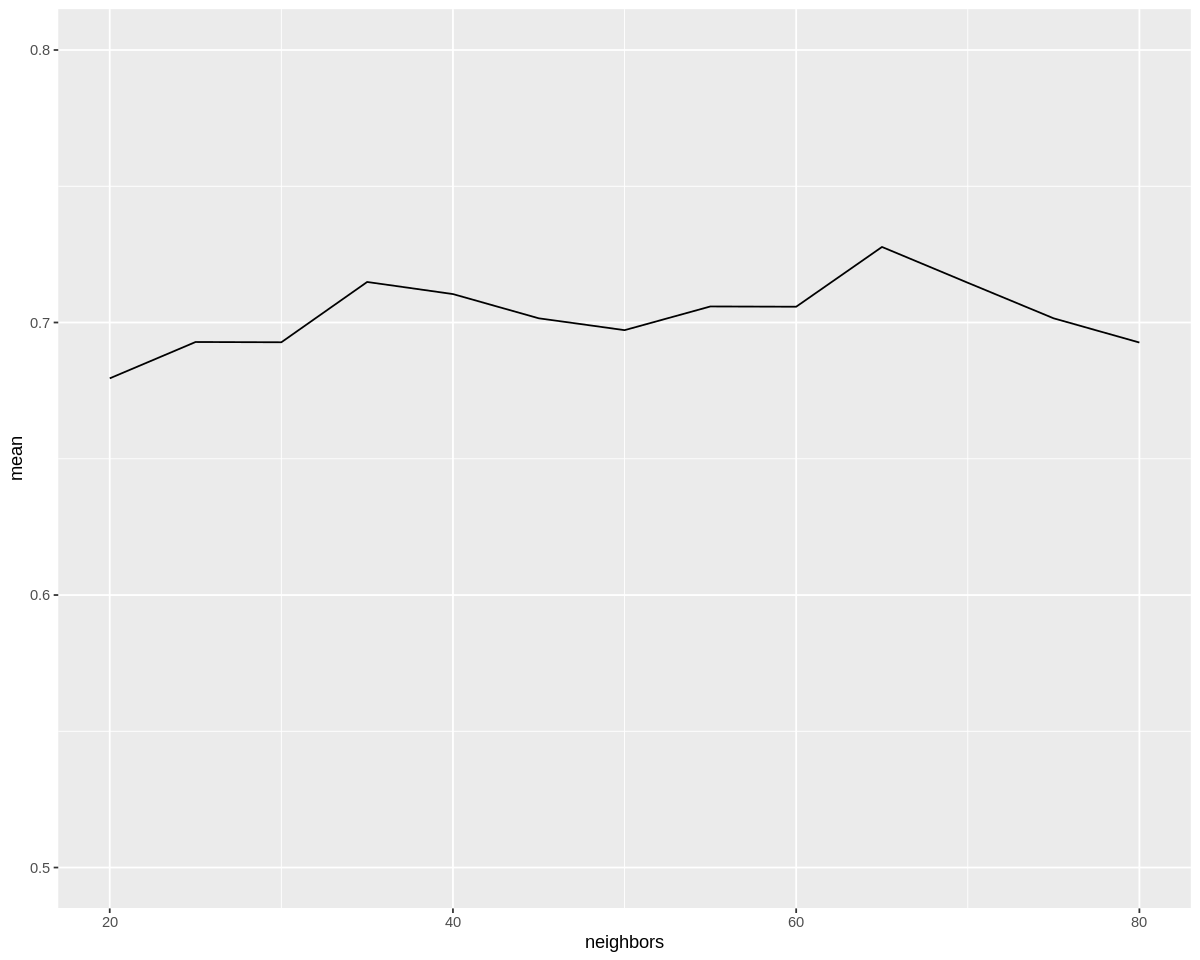

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8)
plot <- ggplot(result, aes(x=neighbors, y= mean)) +
    geom_line() +
    ylim(0.5,.8)
plot

## Methods

#### Data Analysis
As discussed in the introduction, we will be using 5 of the 14 attributes to create a K-nearest neighbors classifier that accurately predicts the class of heart disease of a new patient. Since the accuracy of the KNN classifier can be both positively and negatively affected by which predictors are used, we want to be careful with which ones we select. 

As displayed in the visualizations, each predictor has a different distribution depending on the class, meaning that there appears to be some form of correlation between class and the predictors. When previewing the data with all 14 attributes, an observation regarding the variables that we can make is that it appears many of the variables have data that acts like classes. For example, sex is either a 0 or 1 and chest pain is an integer value from 1 to 4. Since they only give us limited data, choosing a predictor with a wide range of values will be more useful for our classifier. In addition to this fact, we used the distributions and common knowledge about the data, to determine that the predictors we want to continue to investigate are age, blood pressure, cholesterol, max heart rate, and ST depression.

Now that we have determined which predictors we will be using, when making the K-nearest neighbor classifier, we will want to ensure that all of the predictors have been standardized before proceeding. Then, we will want to tune the classifier to figure out which K-value leads to the highest accuracy. By using a process such as cross fold validation, we hope to test the classifier with many possible values of K in order to determine which value leads to the heighest estimated accuracy. Afterwards, we can test our classifier with the test data to determine how accurate it truly is.

#### Visualizations
Since we have decided on using 5 predictors, one way that we can visualize the results is by picking two of the predictors that have clear boundaries between the classes and plotting them on a scatter plot with the points coloured and shaped based on the class. This visualization will demonstrate how depending on the value of two of the predictors, a different class of heart disease is predicted.

Below is an example of a scatter plot displaying maximum heart rate and blood pressure between the classes of 0, 3 and 4.

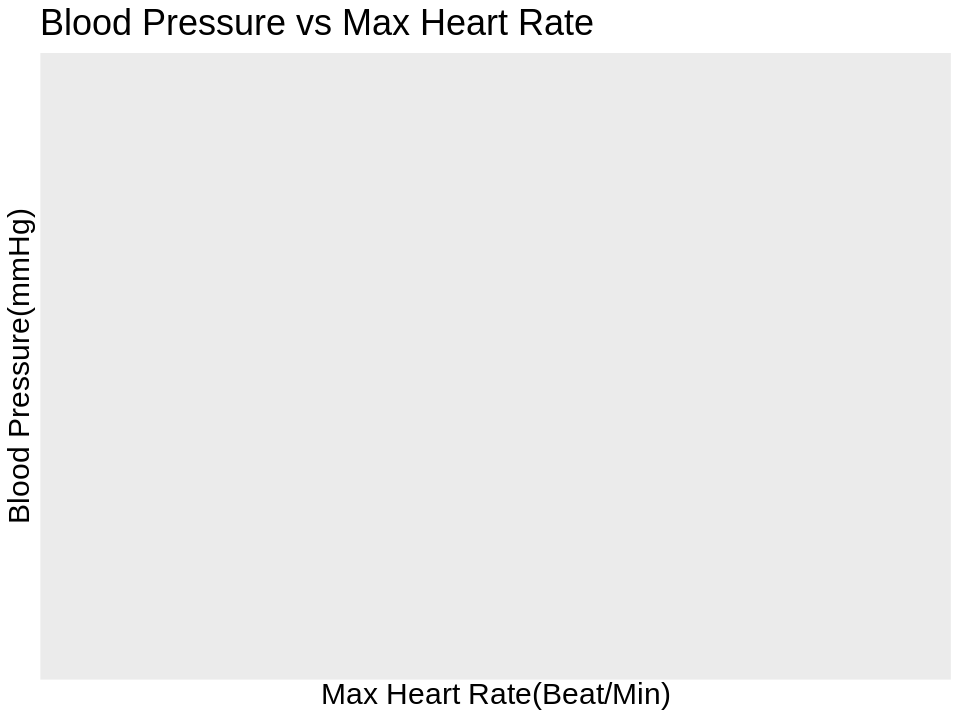

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
limited_classes <- filter(heart_data, Class == 0 | Class == 4 | Class == 3)
ggplot(limited_classes, aes(x=trestbps,y=thalach,color=Class,shape=Class)) +
    geom_point() +
    labs(x="Max Heart Rate(Beat/Min)", y= "Blood Pressure(mmHg)", title="Blood Pressure vs Max Heart Rate") +
    theme(text = element_text(size=18))

Although the distinction among the three classes is not very clear in the example plot above, the distinction between class 0 (no presence of heart disease) and 3/4 (presence of heart disease) is quite clear. By just comparing the two predictors used in the example, it would be a reasonable to predict that a person with low blood pressure (under 120mmHg) and a high max heart rate (over 150 BPM) will likely have some form of heart disease.

### Outcomes and Significance
When using the KNN classifier in our project, every point will have the same weight. One thing that we could consider for future versions of the classifier is, does weighting the points based on how close they are to the new observation increase the accuracy of the classifier?

As outlined in the introduction, with this project we want to determine if the variables we chose act as good predictors for our KNN classifier. Then, using those predictors, we will create an accurate classifier to detect the different classes of heart disease. Should this classifier be accurate, it could have profound effects on the medical world, as we would be able to detect different stages of heart disease using general medical data about an individual. In addition, we could also extend this classifier to attempt to classify other forms of common diseases such as cancer.